In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os

# Check available data files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-09-01 12:57:29.595467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756731449.792789      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756731449.847957      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/pdb14189/PDB14189_N.txt
/kaggle/input/pdb14189/PDB14189_P.txt


In [2]:
def print_file(filename):
    with open(filename, 'r') as file:
        print(f"First 5 lines of file {filename}")
        for i, line in enumerate(file):
            if i < 5:
                print(line.strip())
            else:
                break

print_file('/kaggle/input/pdb14189/PDB14189_N.txt')
print_file('/kaggle/input/pdb14189/PDB14189_P.txt')

First 5 lines of file /kaggle/input/pdb14189/PDB14189_N.txt
>Q9X4M1
MEKILAINAGSSTLKWQLFEMPSETVIAKGMIDRLGLSDSVFTAKYGDNQKFKEVQDVTTHEMAATLLLTRLKELGIVSHLDEITGVGHRVVGGGEAFSDSMVINPVALDEINRLAEYAPLHNPTQAYYIKIFTALLPGVPQVAVFDTSFYSTLAPENYLYSIPQEYYQTFGARKYGAHGTSHRYVAHRAAEILGTPLESQKMITLHLGSGASITAVQDGHAVDTSMGFTPLAGITMGTRSGDIDVSLVAFLAKKLEITMPEMIDILNHKSGLLGISELSPDMRDLEETAATRPQSALALSIFVNRVVKYVGSYVALMNGIDTLVFTAGSGENGSELRADICKQLACFGVKLDEEKNNVRSQERIISADDSKVKVLIVPTNEELMIARDVMRLK
>Q5L8C0
MSKLHIKKGDTVYVNAGEDKGKTGRVLKVLVKEGRAIVEGINMVSKSTKPNAKNPQGGIVKQEAPIHISNLNPVDPKTGKATRVGRKVSSEGTLVRYSKKSGEEIK
>Q6G461
First 5 lines of file /kaggle/input/pdb14189/PDB14189_P.txt
>Q6A8L0
MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGNPTLYDAIQKAKKSSVPNDNITRAVKRGSGEGADAVNYETIMYEAYGPAGVAILIECLTDNRNRAVSDVRVAVTRNGGTMADGGSVQRLFQRKGVVSVSKTYEVEEGRKTETREVDEDQLMEATIDAEPEDIVDEGEVFEIISDPSAVVDVRKAVQGAGIDYDSAEVSFKPDFTQRVELEDARKLYRILDALEDLDDVQNVFSNVDIPAEVAAALDEEE
>Q7V7T9
MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQNTFILWIHQVQRDDGSSLFGFPERRER

In [3]:
def load_fasta_data(positive_file, negative_file):
    """Load protein sequences from FASTA files"""
    
    def parse_fasta(file_path):
        sequences = []
        current_seq = ""
        
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if current_seq:
                        sequences.append(current_seq)
                        current_seq = ""
                else:
                    current_seq += line
            
            # Add last sequence
            if current_seq:
                sequences.append(current_seq)
        
        return sequences
    
    # Load positive (DNA-binding) and negative sequences
    positive_sequences = parse_fasta(positive_file)
    negative_sequences = parse_fasta(negative_file)
    
    # Create labels
    positive_labels = [1] * len(positive_sequences)
    negative_labels = [0] * len(negative_sequences)
    
    # Combine data
    all_sequences = positive_sequences + negative_sequences
    all_labels = positive_labels + negative_labels
    
    print(f"Loaded {len(positive_sequences)} positive and {len(negative_sequences)} negative sequences")
    print(f"Total sequences: {len(all_sequences)}")
    
    return all_sequences, all_labels

def preprocess_sequences(sequences, max_length=512):
    """Convert protein sequences to numerical format"""
    
    # Amino acid to integer mapping (same as in paper)
    aa_to_int = {
        'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 
        'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14,
        'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20, 
        'X': 0, 'U': 0, 'O': 0, 'B': 0, 'Z': 0, 'J': 0  # Unknown/rare amino acids
    }
    
    encoded_sequences = []
    for seq in sequences:
        # Convert to uppercase and encode
        encoded = [aa_to_int.get(aa, 0) for aa in seq.upper()]
        
        # Truncate or pad to max_length
        if len(encoded) > max_length:
            encoded = encoded[:max_length]
        else:
            encoded.extend([0] * (max_length - len(encoded)))
        
        encoded_sequences.append(encoded)
    
    return np.array(encoded_sequences)

In [4]:
# ==================================================
# EXPLORATORY DATA ANALYSIS
# ==================================================
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

def exploratory_data_analysis(sequences, labels):
    """Comprehensive EDA for protein sequence dataset"""
    
    # Basic dataset statistics
    print("=" * 60)
    print("DATASET OVERVIEW")
    print("=" * 60)
    total_sequences = len(sequences)
    positive_count = sum(labels)
    negative_count = total_sequences - positive_count
    
    print(f"Total sequences: {total_sequences:,}")
    print(f"Positive (DNA-binding) sequences: {positive_count:,} ({positive_count/total_sequences*100:.1f}%)")
    print(f"Negative (Non-DNA-binding) sequences: {negative_count:,} ({negative_count/total_sequences*100:.1f}%)")
    print(f"Class balance ratio: {positive_count/negative_count:.2f}")
    
    # Sequence length analysis
    lengths = [len(seq) for seq in sequences]
    print(f"\nSequence length statistics:")
    print(f"  Min length: {min(lengths)}")
    print(f"  Max length: {max(lengths)}")
    print(f"  Mean length: {np.mean(lengths):.1f}")
    print(f"  Median length: {np.median(lengths):.1f}")
    print(f"  Std deviation: {np.std(lengths):.1f}")
    
    # Amino acid composition analysis
    all_amino_acids = ''.join(sequences)
    aa_counter = Counter(all_amino_acids)
    total_aa = sum(aa_counter.values())
    print(f"\nTotal amino acids: {total_aa:,}")
    print(f"Unique amino acids found: {len(aa_counter)}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Protein Sequence Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')
    
    # 1. Sequence length distribution
    axes[0, 0].hist(lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(lengths):.1f}')
    axes[0, 0].axvline(np.median(lengths), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(lengths):.1f}')
    axes[0, 0].set_xlabel('Sequence Length')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Distribution of Protein Sequence Lengths')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Class distribution pie chart
    class_counts = [negative_count, positive_count]
    class_labels = ['Non-DNA-binding', 'DNA-binding']
    colors = ['lightcoral', 'lightblue']
    wedges, texts, autotexts = axes[0, 1].pie(class_counts, labels=class_labels, autopct='%1.1f%%', 
                                              colors=colors, startangle=90, explode=(0.05, 0.05))
    axes[0, 1].set_title('Class Distribution')
    
    # 3. Amino acid frequency (top 20)
    aa_freq = dict(sorted(aa_counter.items(), key=lambda x: x[1], reverse=True))
    top_20_aa = dict(list(aa_freq.items())[:20])
    
    bars = axes[1, 0].bar(top_20_aa.keys(), top_20_aa.values(), color='lightgreen', edgecolor='black')
    axes[1, 0].set_xlabel('Amino Acid')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Top 20 Amino Acid Frequencies')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Add frequency labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    # 4. Length distribution by class
    pos_lengths = [len(sequences[i]) for i, label in enumerate(labels) if label == 1]
    neg_lengths = [len(sequences[i]) for i, label in enumerate(labels) if label == 0]
    
    axes[1, 1].hist(pos_lengths, bins=30, alpha=0.6, label='DNA-binding', color='lightblue', density=True)
    axes[1, 1].hist(neg_lengths, bins=30, alpha=0.6, label='Non-DNA-binding', color='lightcoral', density=True)
    axes[1, 1].set_xlabel('Sequence Length')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Sequence Length Distribution by Class')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison between classes
    print("\n" + "=" * 60)
    print("CLASS-WISE SEQUENCE LENGTH COMPARISON")
    print("=" * 60)
    print(f"DNA-binding proteins:")
    print(f"  Count: {len(pos_lengths):,}")
    print(f"  Mean length: {np.mean(pos_lengths):.1f}")
    print(f"  Median length: {np.median(pos_lengths):.1f}")
    print(f"  Std deviation: {np.std(pos_lengths):.1f}")
    
    print(f"\nNon-DNA-binding proteins:")
    print(f"  Count: {len(neg_lengths):,}")
    print(f"  Mean length: {np.mean(neg_lengths):.1f}")
    print(f"  Median length: {np.median(neg_lengths):.1f}")
    print(f"  Std deviation: {np.std(neg_lengths):.1f}")
    
    # Amino acid composition by class (top 10)
    pos_sequences = [sequences[i] for i, label in enumerate(labels) if label == 1]
    neg_sequences = [sequences[i] for i, label in enumerate(labels) if label == 0]
    
    pos_aa_counter = Counter(''.join(pos_sequences))
    neg_aa_counter = Counter(''.join(neg_sequences))
    
    print(f"\n" + "=" * 60)
    print("TOP 10 AMINO ACIDS BY CLASS")
    print("=" * 60)
    print("DNA-binding proteins (top 10):")
    for aa, count in pos_aa_counter.most_common(10):
        percentage = (count / sum(pos_aa_counter.values())) * 100
        print(f"  {aa}: {count:,} ({percentage:.1f}%)")
    
    print("\nNon-DNA-binding proteins (top 10):")
    for aa, count in neg_aa_counter.most_common(10):
        percentage = (count / sum(neg_aa_counter.values())) * 100
        print(f"  {aa}: {count:,} ({percentage:.1f}%)")
    
    return {
        'total_sequences': total_sequences,
        'positive_count': positive_count,
        'negative_count': negative_count,
        'sequence_lengths': lengths,
        'amino_acid_counts': aa_counter,
        'pos_lengths': pos_lengths,
        'neg_lengths': neg_lengths
    }


Loaded 7129 positive and 7060 negative sequences
Total sequences: 14189
Running Exploratory Data Analysis...
DATASET OVERVIEW
Total sequences: 14,189
Positive (DNA-binding) sequences: 7,129 (50.2%)
Negative (Non-DNA-binding) sequences: 7,060 (49.8%)
Class balance ratio: 1.01

Sequence length statistics:
  Min length: 47
  Max length: 4911
  Mean length: 425.3
  Median length: 327.0
  Std deviation: 373.2

Total amino acids: 6,034,402
Unique amino acids found: 24


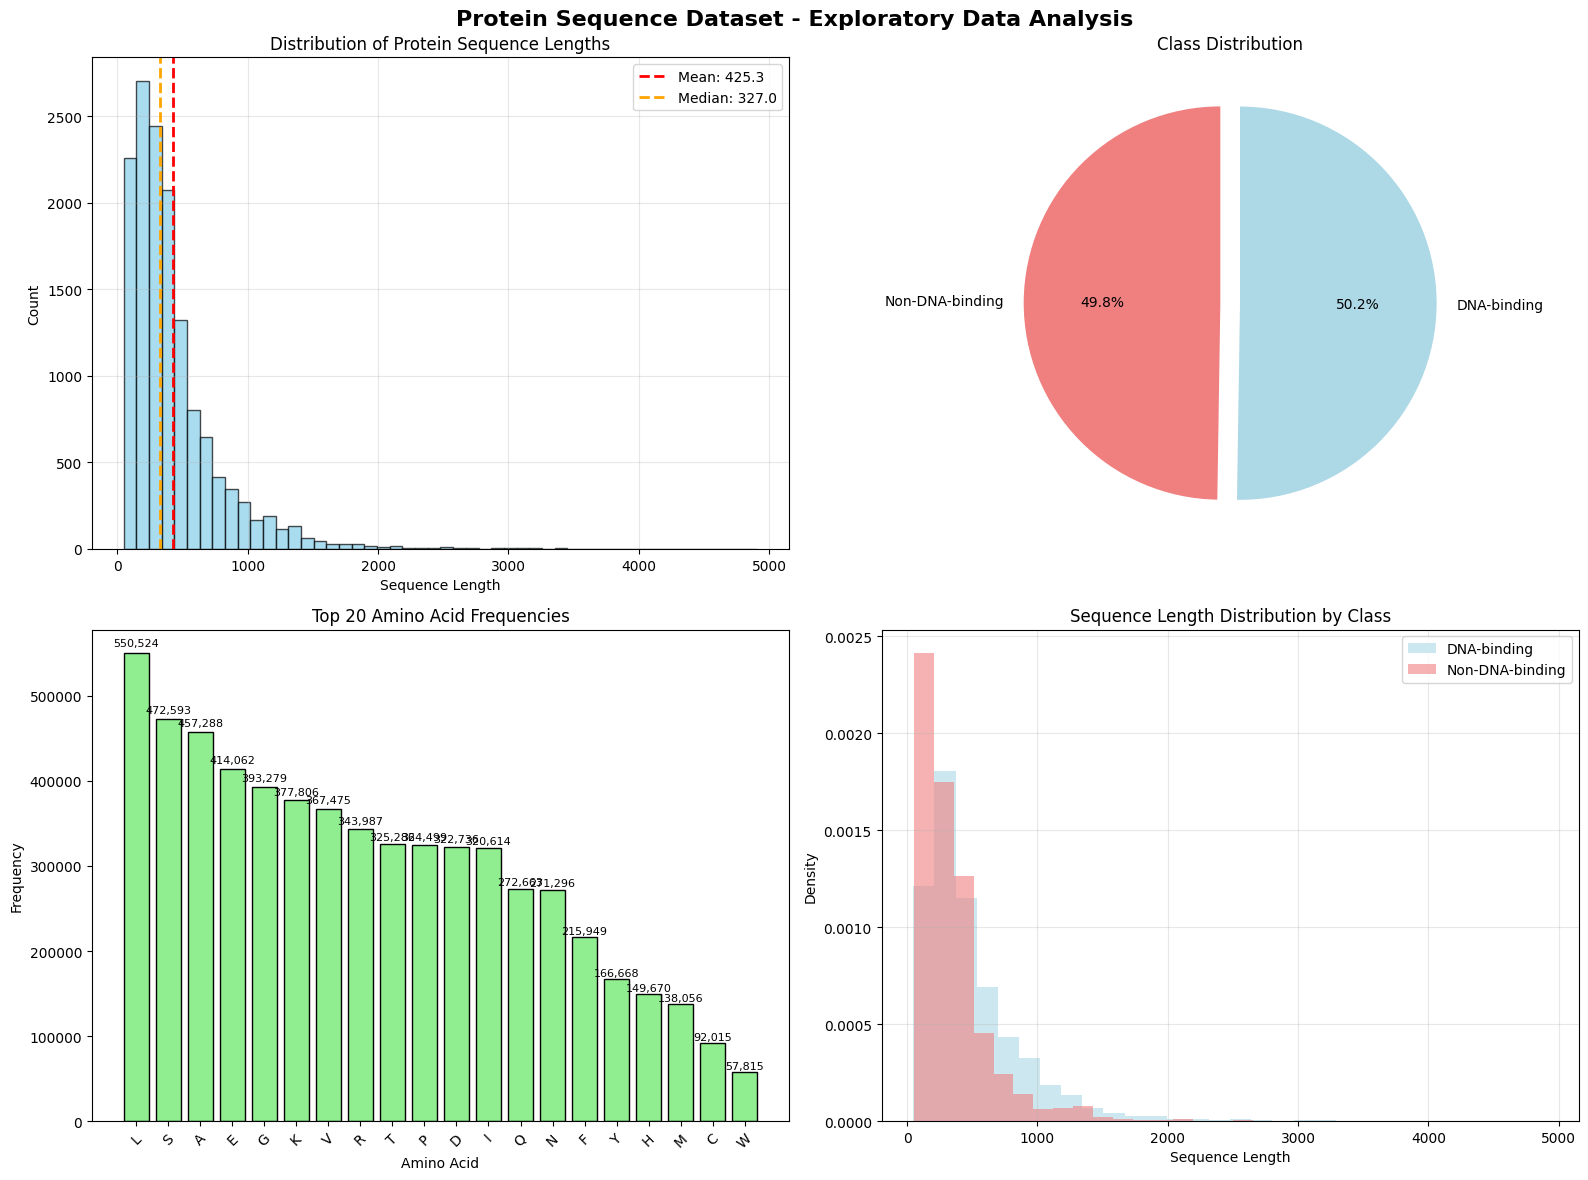


CLASS-WISE SEQUENCE LENGTH COMPARISON
DNA-binding proteins:
  Count: 7,129
  Mean length: 498.8
  Median length: 378.0
  Std deviation: 412.7

Non-DNA-binding proteins:
  Count: 7,060
  Mean length: 351.1
  Median length: 275.0
  Std deviation: 311.4

TOP 10 AMINO ACIDS BY CLASS
DNA-binding proteins (top 10):
  S: 314,475 (8.8%)
  L: 313,597 (8.8%)
  A: 251,112 (7.1%)
  E: 246,549 (6.9%)
  K: 228,103 (6.4%)
  G: 213,506 (6.0%)
  P: 209,920 (5.9%)
  R: 203,770 (5.7%)
  T: 192,731 (5.4%)
  V: 192,475 (5.4%)

Non-DNA-binding proteins (top 10):
  L: 236,927 (9.6%)
  A: 206,176 (8.3%)
  G: 179,773 (7.3%)
  V: 175,000 (7.1%)
  E: 167,513 (6.8%)
  S: 158,118 (6.4%)
  I: 150,908 (6.1%)
  K: 149,703 (6.0%)
  R: 140,217 (5.7%)
  D: 136,078 (5.5%)


In [5]:
sequences, labels = load_fasta_data(
    positive_file='/kaggle/input/pdb14189/PDB14189_P.txt',
    negative_file='/kaggle/input/pdb14189/PDB14189_N.txt'
)

# Run EDA
print("Running Exploratory Data Analysis...")
eda_results = exploratory_data_analysis(sequences, labels)

In [6]:
def build_cnn_bilstm(
    vocab_size=21,        # 20 amino acids + padding
    max_len=512,          # max sequence length
    embedding_dim=64,     # same as paper
    cnn_filters=128,      # same as paper
    bilstm_units=128,     # same as paper
    dropout_rate=0.3,     # same as paper
    num_classes=1         # binary classification
):
    """CNN+BiLSTM model"""
    
    # Input layer
    inputs = Input(shape=(max_len,), name='sequence')
    
    # Embedding layer (same as paper: 64-dim)
    x = Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim, 
        mask_zero=True,
        name='amino_acid_embedding'
    )(inputs)
    x = Dropout(0.2)(x)
    
    # CNN layers for local feature extraction
    x = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', activation='relu', name='conv1d_1')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_1')(x)
    
    x = Conv1D(filters=cnn_filters//2, kernel_size=3, padding='same', activation='relu', name='conv1d_2')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_2')(x)
    
    x = Conv1D(filters=cnn_filters//4, kernel_size=3, padding='same', activation='relu', name='conv1d_3')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_3')(x)
    
    # Bidirectional LSTM for sequence modeling
    x = Bidirectional(LSTM(units=bilstm_units, return_sequences=True), name='bilstm_1')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Bidirectional(LSTM(units=bilstm_units//2, return_sequences=False), name='bilstm_2')(x)
    x = Dropout(dropout_rate)(x)
    
    # Dense classification layers
    x = Dense(128, activation='relu', name='dense_1')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(64, activation='relu', name='dense_2')(x)
    x = Dropout(dropout_rate/2)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='CNN_BiLSTM')
    
    return model

def evaluate_model(model, X_test, y_test):
    """Comprehensive model evaluation"""
    
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC-ROC: {auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-DNA-binding', 'DNA-binding']))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }


In [7]:
import matplotlib.pyplot as plt

def plot_metrics(history, figsize=(16, 10), save_path=None):
    """
    Plot training and validation metrics from Keras history object
    
    Parameters:
    -----------
    history : keras.callbacks.History
        History object returned from model.fit()
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the plot (e.g., 'training_metrics.png')
    """
    
    # Extract metrics (exclude validation metrics to avoid duplicates)
    metrics = [metric for metric in history.history.keys() if not metric.startswith('val_')]
    n_metrics = len(metrics)
    
    if n_metrics == 0:
        print("No metrics found in history object")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, (n_metrics + 1) // 2, figsize=figsize)
    if n_metrics == 1:
        axes = [axes]
    elif n_metrics <= 2:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Color scheme
    train_color = '#2E86AB'  # Blue
    val_color = '#A23B72'    # Pink/Red
    
    for i, metric in enumerate(metrics):
        ax = axes[i] if n_metrics > 1 else axes[0]
        
        # Get training metric values
        train_values = history.history[metric]
        epochs = range(1, len(train_values) + 1)
        
        # Plot training metric
        ax.plot(epochs, train_values, color=train_color, linewidth=2, 
                label=f'Training {metric}', marker='o', markersize=3)
        
        # Plot validation metric if available
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            val_values = history.history[val_metric]
            ax.plot(epochs, val_values, color=val_color, linewidth=2, 
                    label=f'Validation {metric}', marker='s', markersize=3)
            
            # Find best validation score
            if 'loss' in metric:
                best_epoch = np.argmin(val_values) + 1
                best_val = min(val_values)
            else:
                best_epoch = np.argmax(val_values) + 1
                best_val = max(val_values)
            
            # Mark best validation score
            ax.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.7)
            ax.annotate(f'Best: {best_val:.4f}\nEpoch: {best_epoch}', 
                       xy=(best_epoch, best_val), xytext=(best_epoch + len(epochs)*0.1, best_val),
                       fontsize=8, ha='left', va='center',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', color='gray', lw=1))
        
        # Formatting
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel(metric.capitalize(), fontsize=10)
        ax.set_title(f'Model {metric.capitalize()} Over Time', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1, len(train_values))
        
        # Set y-axis limits for better visualization
        if 'loss' in metric:
            ax.set_ylim(bottom=0)
        elif metric in ['accuracy', 'precision', 'recall']:
            ax.set_ylim(0, 1)
    
    # Hide extra subplots if number of metrics is odd
    if n_metrics % 2 == 1 and n_metrics > 1:
        axes[-1].set_visible(False)
    
    # Add overall title
    plt.suptitle('Training History - Model Performance Metrics', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    
    for metric in metrics:
        train_values = history.history[metric]
        val_metric = f'val_{metric}'
        
        print(f"\n{metric.upper()}:")
        print(f"  Final Training {metric}: {train_values[-1]:.4f}")
        
        if val_metric in history.history:
            val_values = history.history[val_metric]
            print(f"  Final Validation {metric}: {val_values[-1]:.4f}")
            
            if 'loss' in metric:
                best_val = min(val_values)
                best_epoch = np.argmin(val_values) + 1
            else:
                best_val = max(val_values)
                best_epoch = np.argmax(val_values) + 1
            
            print(f"  Best Validation {metric}: {best_val:.4f} (Epoch {best_epoch})")
            
            # Calculate improvement/degradation from best to final
            improvement = val_values[-1] - best_val if 'loss' not in metric else best_val - val_values[-1]
            print(f"  Best to Final Change: {improvement:+.4f}")


In [8]:
# Load full dataset first
sequences, labels = load_fasta_data(
    positive_file='/kaggle/input/pdb14189/PDB14189_P.txt',
    negative_file='/kaggle/input/pdb14189/PDB14189_N.txt'
)

# Preprocess the quarter dataset
X = preprocess_sequences(sequences, max_length=512)
y = np.array(labels)

print(f"Preprocessed data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive samples: {np.sum(y)}, Negative samples: {len(y) - np.sum(y)}")


Loaded 7129 positive and 7060 negative sequences
Total sequences: 14189
Preprocessed data shape: (14189, 512)
Labels shape: (14189,)
Positive samples: 7129, Negative samples: 7060


In [9]:
# Create and compile model
model = build_cnn_bilstm()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

I0000 00:00:1756731465.850830      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "CNN_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence (InputLayer)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ amino_acid_embedding            │ (None, 512, 64)        │         1,344 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 512, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1 (MaxPooling1D)      │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 256, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_2 (MaxPooling1D)      │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 128, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_3 (MaxPooling1D)      │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 64, 256)        │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,913 (1.57 MB)

 Trainable params: 410,913 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Split data for training
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_cnn_blstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

Training set: 8513 samples
Validation set: 2838 samples
Test set: 2838 samples


In [11]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1756731477.337099      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6188 - loss: 0.6473 - precision: 0.6239 - recall: 0.6759
Epoch 1: val_accuracy improved from -inf to 0.58069, saving model to best_cnn_blstm_model.h5
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.6190 - loss: 0.6471 - precision: 0.6241 - recall: 0.6758 - val_accuracy: 0.5807 - val_loss: 0.6749 - val_precision: 0.5461 - val_recall: 0.9797 - learning_rate: 0.0010
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6471 - loss: 0.6380 - precision: 0.6350 - recall: 0.7224
Epoch 2: val_accuracy improved from 0.58069 to 0.66385, saving model to best_cnn_blstm_model.h5
267/267 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6471 - loss: 0.6380 - precision: 0.6350 - recall: 0.7223 - val_accuracy: 0.6638 - val_loss: 0.6138 - val_precision: 0.6396 - val_recall: 0.7581 - learning_rate: 0.0010
Epoch 3/50
265/267 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6959 - loss: 0.5906 - precision: 0.7112 - recall: 0.6465
E

In [12]:
# Evaluate model
print("=== CNN+BiLSTM Model Results ===")
results = evaluate_model(model, X_test, y_test)

=== CNN+BiLSTM Model Results ===
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Test Accuracy: 0.7847
Test Precision: 0.7759
Test Recall: 0.8036
Test F1-Score: 0.7895
Test AUC-ROC: 0.8623

Classification Report:
                 precision    recall  f1-score   support

Non-DNA-binding       0.79      0.77      0.78      1412
    DNA-binding       0.78      0.80      0.79      1426

       accuracy                           0.78      2838
      macro avg       0.79      0.78      0.78      2838
   weighted avg       0.79      0.78      0.78      2838


Confusion Matrix:
[[1081  331]
 [ 280 1146]]


In [13]:
# Save results for comparison with transformer model later
import pickle
with open('cnn_blstm_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\nResults saved to 'cnn_blstm_results.pkl'")


Results saved to 'cnn_blstm_results.pkl'
